In [25]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm.contrib import itertools
import pandas as pd
from scipy.stats import truncnorm
from math import prod

In [26]:
DQL_MODEL = {
    "join": ["inner_join", "outer_join", "self_join"],
    "nesting": ["cte", "correlated_subquery", "uncorrelated_subquery"],
    "predicates": ["basic_operators", "logical_operators", "set_operators"]
}

SYNTAX_ELEMENT_COUNT_CAP = 10

# SIM_PARAM_COMPLEXITY_CONVERGATION_FACTOR
REGULATION = 0.5
MAX_TASK_COUNT = 100

In [27]:
def rgbeta(n: int, mean: float, var: float, min: float = 0, max: float = 1) -> float:
    dmin = mean - min
    dmax = max - mean

    if dmin <= 0 or dmax <= 0:
        raise ValueError(f"mean must be between min = {min} and max = {max}")

    if var >= dmin * dmax:
        raise ValueError(
            f"var must be less than (mean - min) * (max - mean) = {dmin * dmax}")

    mx = (mean - min) / (max - min)
    vx = var / (max - min) ** 2

    a = ((1 - mx) / vx - 1 / mx) * mx ** 2
    b = a * (1 / mx - 1)

    x = np.random.beta(a, b, n)
    y = (max - min) * x + min

    return y.tolist()


In [28]:
def calc_complexity(frequency):
    regulation = REGULATION
    #TODO: Stufenfunktion
    if(frequency>=SYNTAX_ELEMENT_COUNT_CAP): return 1
    return ((frequency)**(1/regulation))/(1+((frequency)**(1/regulation))) 

def calc_frequency(complexity):
    regulation = REGULATION
    if(complexity>=1): return SYNTAX_ELEMENT_COUNT_CAP
    x = -complexity/(1-complexity)
    if(x<0): x = x*-1
    return x**regulation

In [29]:
def create_random_task(dql_model: dict[str, list[str]]):
    return {key: [random.randint(0, 7) for _ in dql_model[key]] for key in dql_model}


def create_optimal_task(dql_model: dict[str, list[str]], learner_competency: dict[str, list[float]], scaffolding_bonus: dict[str, list[float]]):
    return {
        key: [
            calc_frequency(learner_competency[key][i] + scaffolding_bonus[key][i]) for i in range(len(dql_model[key]))
        ] for key in dql_model
    }

In [30]:
def calc_task_complexities(task: dict[str, list[int]]):
    return {key: calc_complexity_for_category(category) for key, category in task.items()}


def calc_complexity_for_category(category: list[int]):
    return list(calc_complexity(frequency) for frequency in category)

In [31]:
def create_learner_scaffolded_competence_bonuses(dql_model: dict[str, list[str]], bonus_distribution: tuple[4]):
    return {key: rgbeta(len(dql_model[key]), *bonus_distribution) for key in dql_model}


def sample_from_snd_vectorized_and_normalize(X: list[float], mean=0.5, sd=0.1):
    # Generate random normal samples and normalize
    lower, upper = 0, 1
    a, b = (lower - mean) / sd, (upper - mean) / sd
    samples = truncnorm.rvs(a, b, loc=mean, scale=sd, size=len(X))
    return (samples).tolist()


def create_learner_competencies(dql_model: dict[str, list[str]], mean: float):
    return {key: sample_from_snd_vectorized_and_normalize(dql_model[key], mean) for key in dql_model}


def create_learner_population(learner_count: int, task_count: int, dql_model: dict[str, list[str]], mean_competency: float, bonus_distribution: tuple[4]):
    population = {
        "learner_competencies": [create_learner_competencies(dql_model, mean=mean_competency) for _ in range(learner_count)],
        "scaffolding_competence_bonus_per_step_and_learner": [[create_learner_scaffolded_competence_bonuses(dql_model, bonus_distribution) for _ in range(learner_count)] for _ in range(task_count)]
    }
    return population

In [32]:


def calculate_delta(learner_competency: dict[str, list[str]], task_complexities: dict[str, list[str]], scaffolding_bonus: dict[str, list[str]]):
    result = {}
    for key in learner_competency:
        result[key] = []
        for i in range(len(learner_competency[key])):
            k = learner_competency[key][i]
            c = task_complexities[key][i]
            t = scaffolding_bonus[key][i]
            if (c <= k or c > k + t):
                result[key].append(0)
            else:
                result[key].append(c - k)
    return result


def add_delta_to_competency(competency: dict[str, list[str]], delta: dict[str, list[str]]):
    return {key: [competency[key][i] + delta[key][i] for i in range(len(competency[key]))] for key in competency}

In [33]:
def simulate_task_adaptation(learner_count: int, mean_competency: float, bonus_distribution: tuple[4]):

    learner_population = create_learner_population(
        learner_count, MAX_TASK_COUNT, DQL_MODEL, mean_competency, bonus_distribution)

    simulationLog = [{
        "tasks": [],
        "competencies": [],
        "scaffolding_bonuses": [],
        "deltas": []
    } for _ in range(learner_count)]

    for i, j in itertools.product(range(MAX_TASK_COUNT), range(learner_count)):
        learner_competency = learner_population["learner_competencies"][j]
        aggregated_competency = prod({key: prod(values) for key, values in learner_competency.items()}.values())
        if(aggregated_competency < 1):
            scaffolding_bonus = learner_population["scaffolding_competence_bonus_per_step_and_learner"][i][j]

            # task = create_random_task(dql_model)
            task = create_optimal_task(
                DQL_MODEL, learner_competency, scaffolding_bonus)

            task_complexities = calc_task_complexities(task)
            delta = calculate_delta(
                learner_competency, task_complexities, scaffolding_bonus)

            # update the learner competency in the global learner population
            learner_population["learner_competencies"][j] = add_delta_to_competency(
                learner_competency, delta)    

            simulationLog[j]["tasks"].append(task)
            simulationLog[j]["competencies"].append(learner_competency)
            simulationLog[j]["scaffolding_bonuses"].append(scaffolding_bonus)
            simulationLog[j]["deltas"].append(delta)

    return simulationLog

In [34]:
def plot_simulation_log(simulationLog: dict[str, list[list[float]]], learnerId: int):
    task_count = len(simulationLog[learnerId]["tasks"])
    plt.figure(figsize=(16, 9))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, key in enumerate(DQL_MODEL):
        color = colors[i % len(colors)]

        aggregated_competency_values = []
        aggregated_task_values = []
        aggregated_competency_plus_bonus_values = []
        for i in range(task_count):
            # Get competency value
            competency_values = simulationLog[learnerId]["competencies"][i][key]
            competency_aggregated = sum(
                competency_values)/len(competency_values)
            aggregated_competency_values.append(competency_aggregated)

            # Get task complexity value
            task_values = calc_task_complexities(
                simulationLog[learnerId]["tasks"][i])[key]
            task_aggregated = sum(task_values)/len(task_values)
            aggregated_task_values.append(task_aggregated)

            scaffolding_bonus_values = simulationLog[learnerId]["scaffolding_bonuses"][i][key]
            # Add the scaffolding bonus to the competency value
            competency_plus_bonus_values = [
                a + b for a, b in zip(scaffolding_bonus_values, competency_values)]
            competency_plus_bonus_aggregated = sum(
                competency_plus_bonus_values)/len(competency_plus_bonus_values)
            aggregated_competency_plus_bonus_values.append(
                competency_plus_bonus_aggregated)

        plt.plot(range(task_count), aggregated_competency_values,
                 color=color, label=f'{key} competency')
        plt.plot(range(task_count), aggregated_task_values,
                 '.', color=color, label=f'{key} task')
        plt.plot(range(task_count), aggregated_competency_plus_bonus_values,
                 '--', color=color, label=f'{key} competency + scaffolding bonus')

    plt.ylim(0, 1)
    plt.xlim(0, task_count-1)
    plt.ylabel("Competency")
    plt.xlabel("Step")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(
        f"sql_task_adaptation_{learnerId}.png", dpi=300, bbox_inches="tight")
    
    
def plot_mean_simulation_log(simulationLog):
    learner_count = len(simulationLog)
    # Find the maximum task count among all learners
    max_task_count = max(len(log["tasks"]) for log in simulationLog)
    
    plt.figure(figsize=(16, 9))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    # For each DQL category
    for i, key in enumerate(DQL_MODEL):
        color = colors[i % len(colors)]
        
        # Initialize lists to store aggregated values
        mean_competency_values = [[] for _ in range(max_task_count)]
        mean_task_values = [[] for _ in range(max_task_count)]
        mean_competency_plus_bonus_values = [[] for _ in range(max_task_count)]
        
        # Collect values for each learner and task
        for learner_id in range(learner_count):
            learner_task_count = len(simulationLog[learner_id]["tasks"])
            
            for task_id in range(learner_task_count):
                # Get competency value
                competency_values = simulationLog[learner_id]["competencies"][task_id][key]
                competency_aggregated = sum(competency_values)/len(competency_values)
                mean_competency_values[task_id].append(competency_aggregated)
                
                # Get task complexity value
                task_values = calc_task_complexities(simulationLog[learner_id]["tasks"][task_id])[key]
                task_aggregated = sum(task_values)/len(task_values)
                mean_task_values[task_id].append(task_aggregated)
                
                # Get scaffolding bonus
                scaffolding_bonus_values = simulationLog[learner_id]["scaffolding_bonuses"][task_id][key]
                # Add scaffolding bonus to competency
                competency_plus_bonus_values = [a + b for a, b in zip(scaffolding_bonus_values, competency_values)]
                competency_plus_bonus_aggregated = sum(competency_plus_bonus_values)/len(competency_plus_bonus_values)
                mean_competency_plus_bonus_values[task_id].append(competency_plus_bonus_aggregated)
        
        # Calculate means across learners for each task
        mean_competency_across_learners = [sum(values)/len(values) if values else 0 for values in mean_competency_values]
        mean_task_across_learners = [sum(values)/len(values) if values else 0 for values in mean_task_values]
        mean_competency_plus_bonus_across_learners = [sum(values)/len(values) if values else 0 for values in mean_competency_plus_bonus_values]
        
        # Plot only valid data points (up to the maximum task count with data)
        valid_task_count = max(i for i, values in enumerate(mean_competency_values) if values) + 1
        
        plt.plot(range(valid_task_count), mean_competency_across_learners[:valid_task_count],
                color=color, label=f'{key} competency')
        plt.plot(range(valid_task_count), mean_task_across_learners[:valid_task_count],
                '.', color=color, label=f'{key} task')
        plt.plot(range(valid_task_count), mean_competency_plus_bonus_across_learners[:valid_task_count],
                '--', color=color, label=f'{key} competency + scaffolding bonus')
    
    plt.ylim(0, 1)
    plt.xlim(0, valid_task_count-1)
    plt.ylabel("Mean Competency")
    plt.xlabel("Task Number")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig("sql_task_adaptation_mean.png", dpi=300, bbox_inches="tight")

In [35]:
def saveData(simulationLog, fileName):
    records = []
    order_id = 1
    problem_id = 1

    # Iterate through each student 
    for studentId in range(len(simulationLog)):
        for taskIndex in range(len(simulationLog[studentId]["tasks"])):
            task_order_id = order_id  # Create one order_id per task
            # Iterate through categories
            for category_i, (category_name, category_elements) in enumerate(DQL_MODEL.items()):
                # Iterate through elements in category
                for element_i, element in enumerate(category_elements):
                    # Get delta for this element
                    delta = simulationLog[studentId]["deltas"][taskIndex][category_name][element_i]
                    
                    # Create record with zero-padded IDs
                    # Calculate position: (category_i * elements_per_category) + element_i
                    skill_position = (category_i * len(category_elements)) + element_i + 1
                    record = {
                        'order_id': f'{order_id:08d}',
                        'user_id': f'{studentId+1:06d}',
                        'sequence_id': f'{studentId+1:06d}',
                        'skill_id': skill_position,
                        'problem_id': f'{problem_id:08d}',
                        # todo: add problem Id and check if other ids are unique
                        'correct': 1 if delta > 0 else 0
                    }
                    records.append(record)
                    order_id += 1  
            problem_id += 1

    # Create and save dataframe
    df = pd.DataFrame(records)
    df.to_csv(fileName+'.csv', index=False, sep=',')

100%|██████████| 100000/100000 [00:00<00:00, 334243.44it/s]


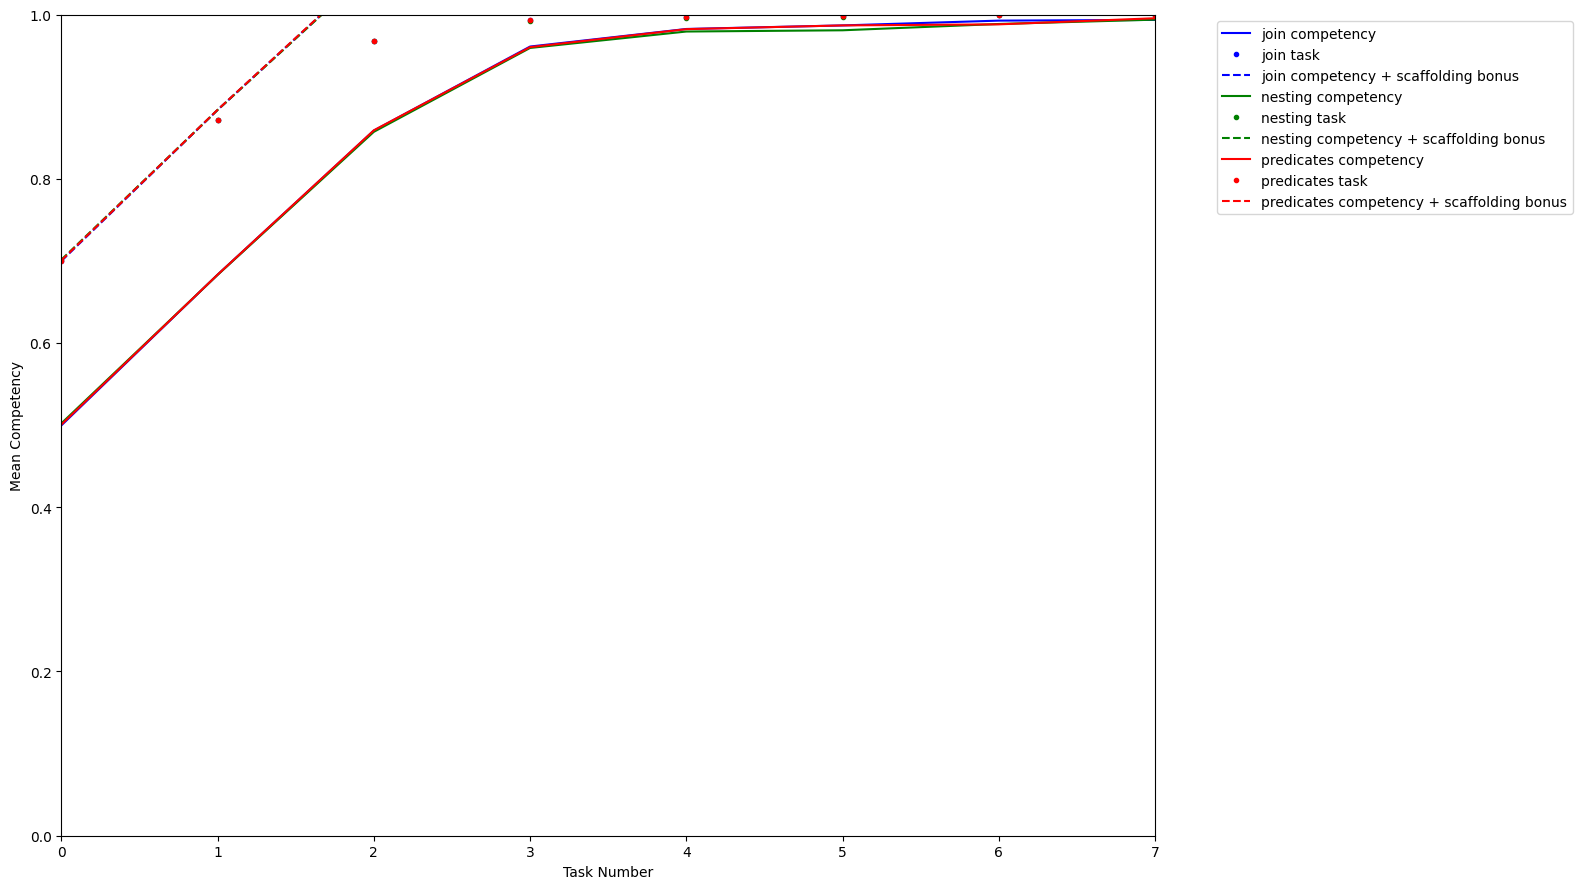

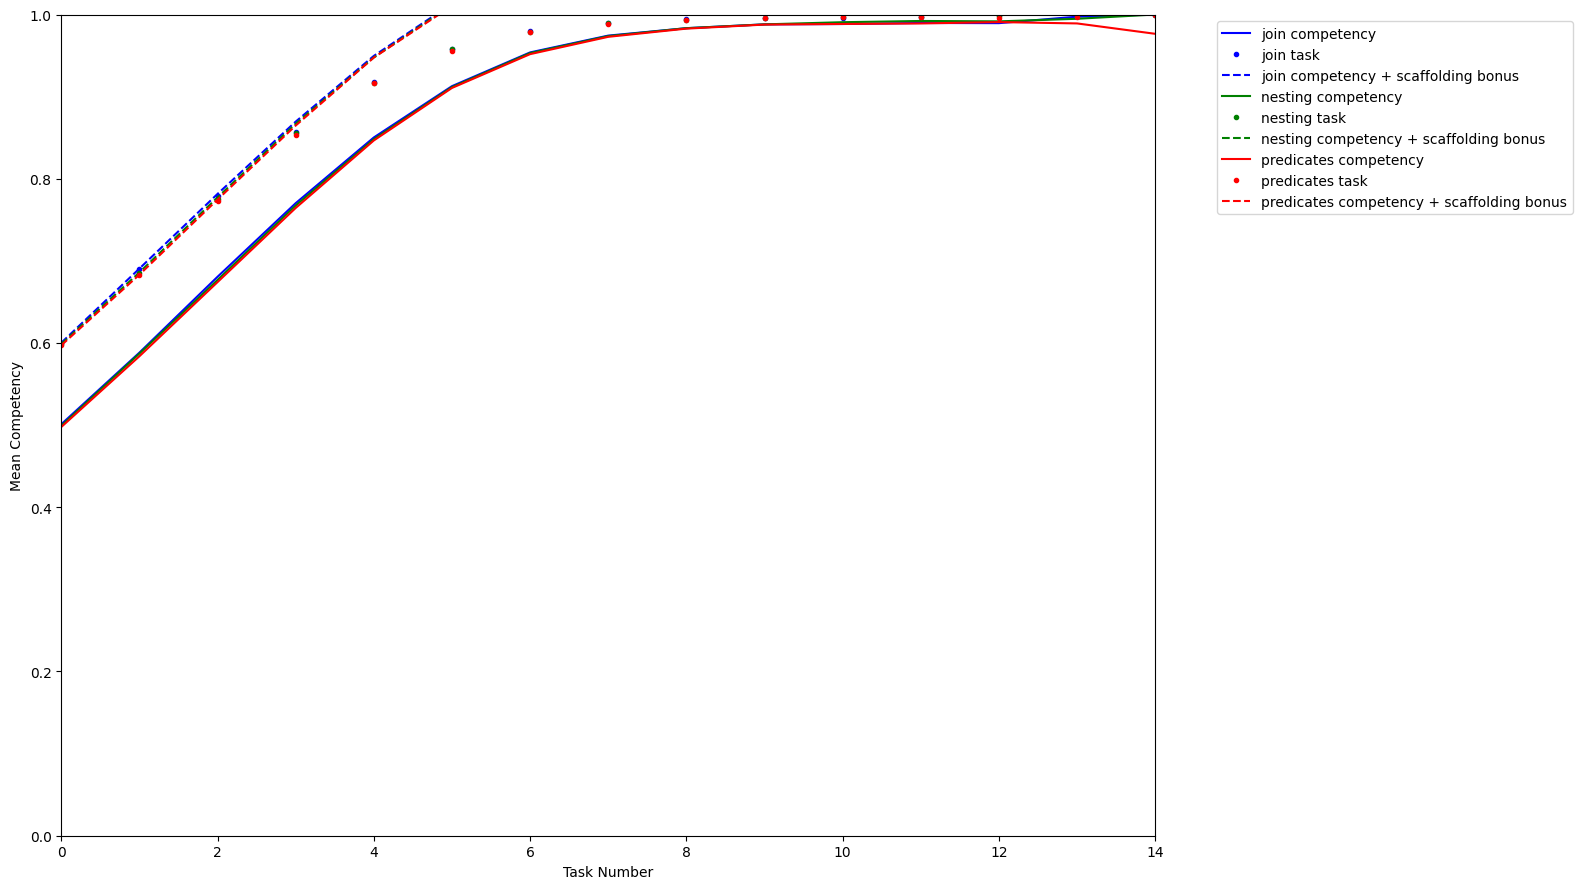

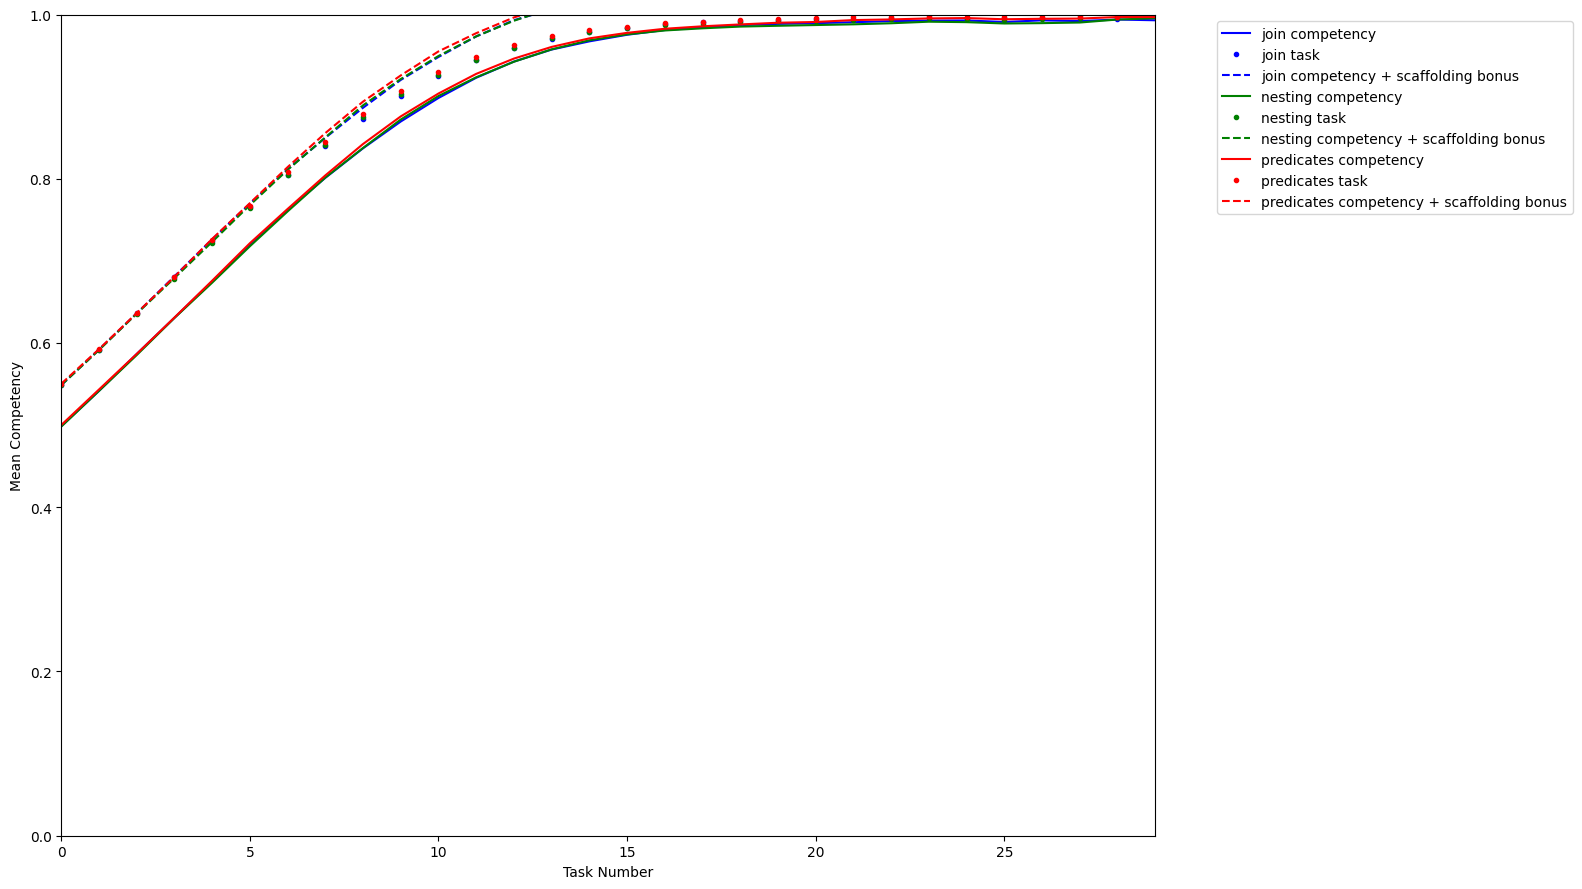

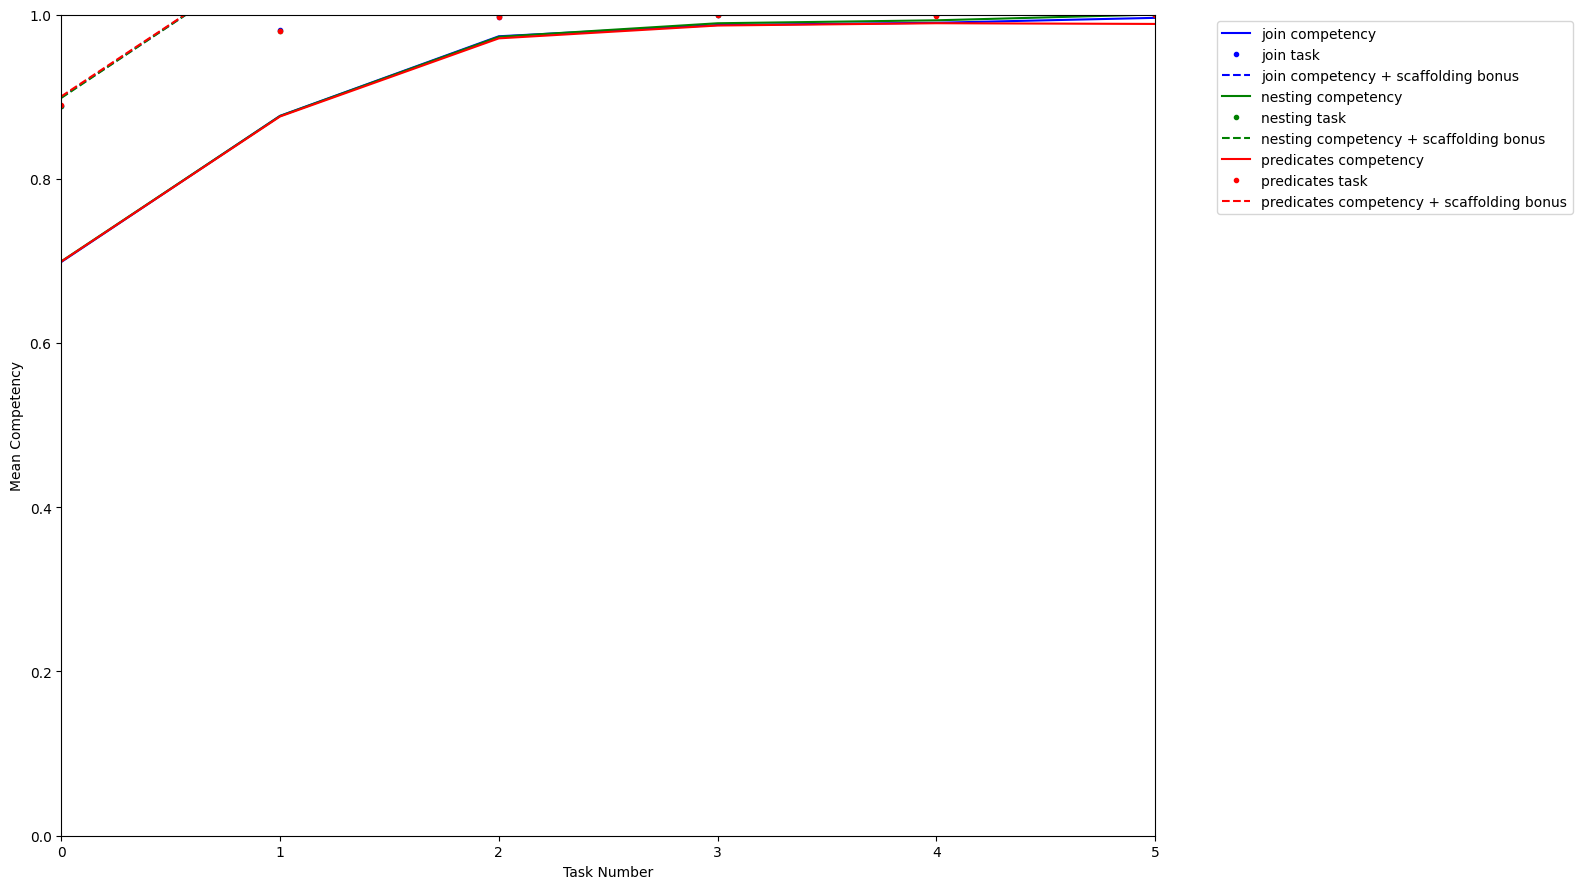

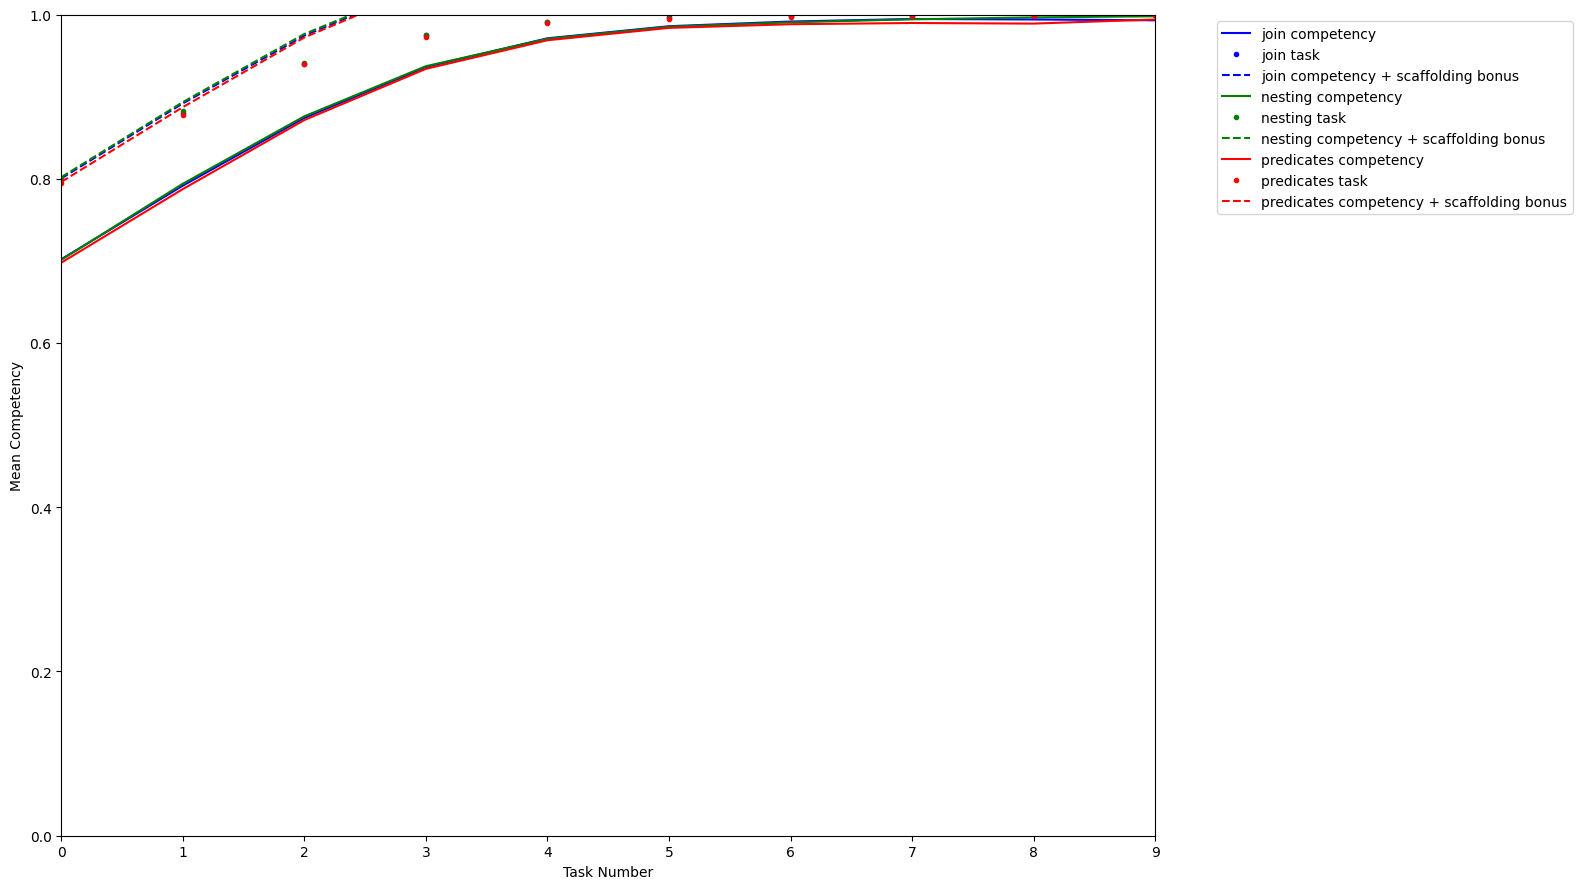

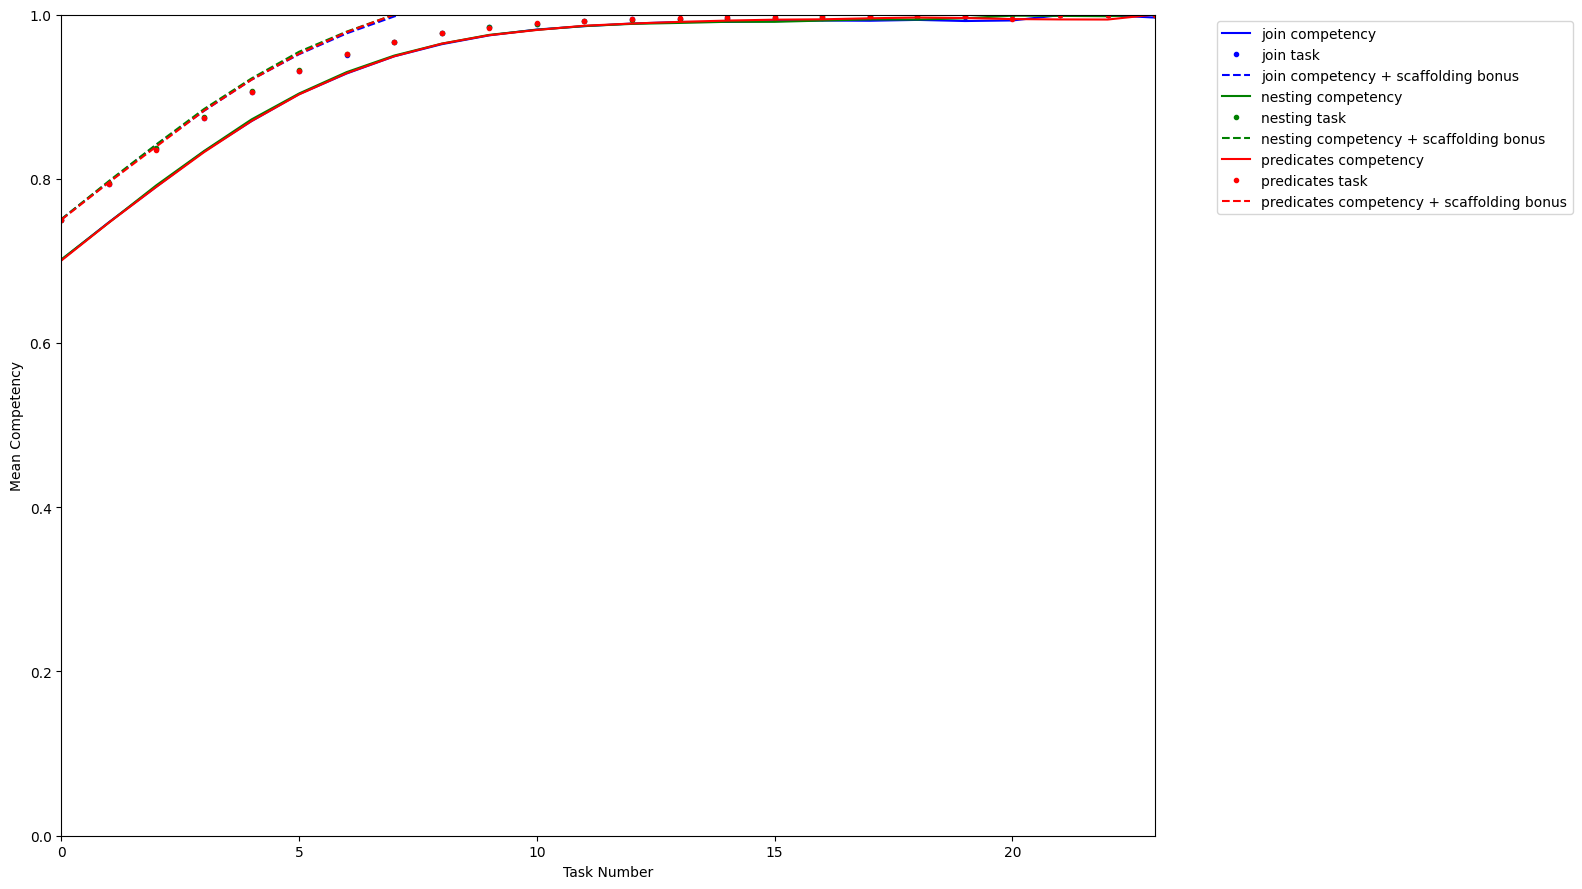

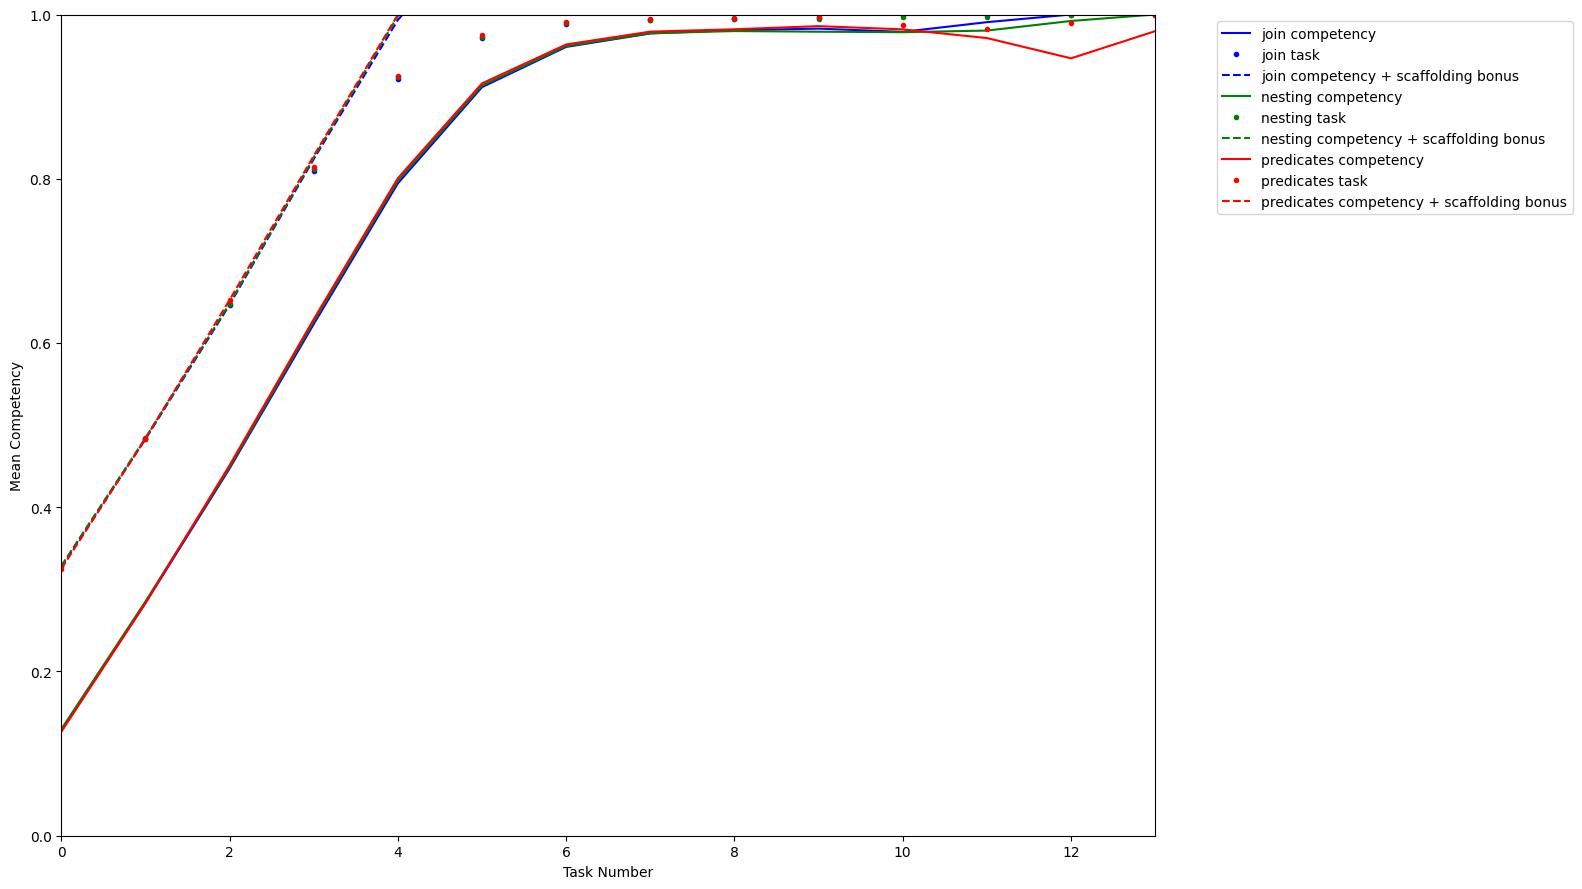

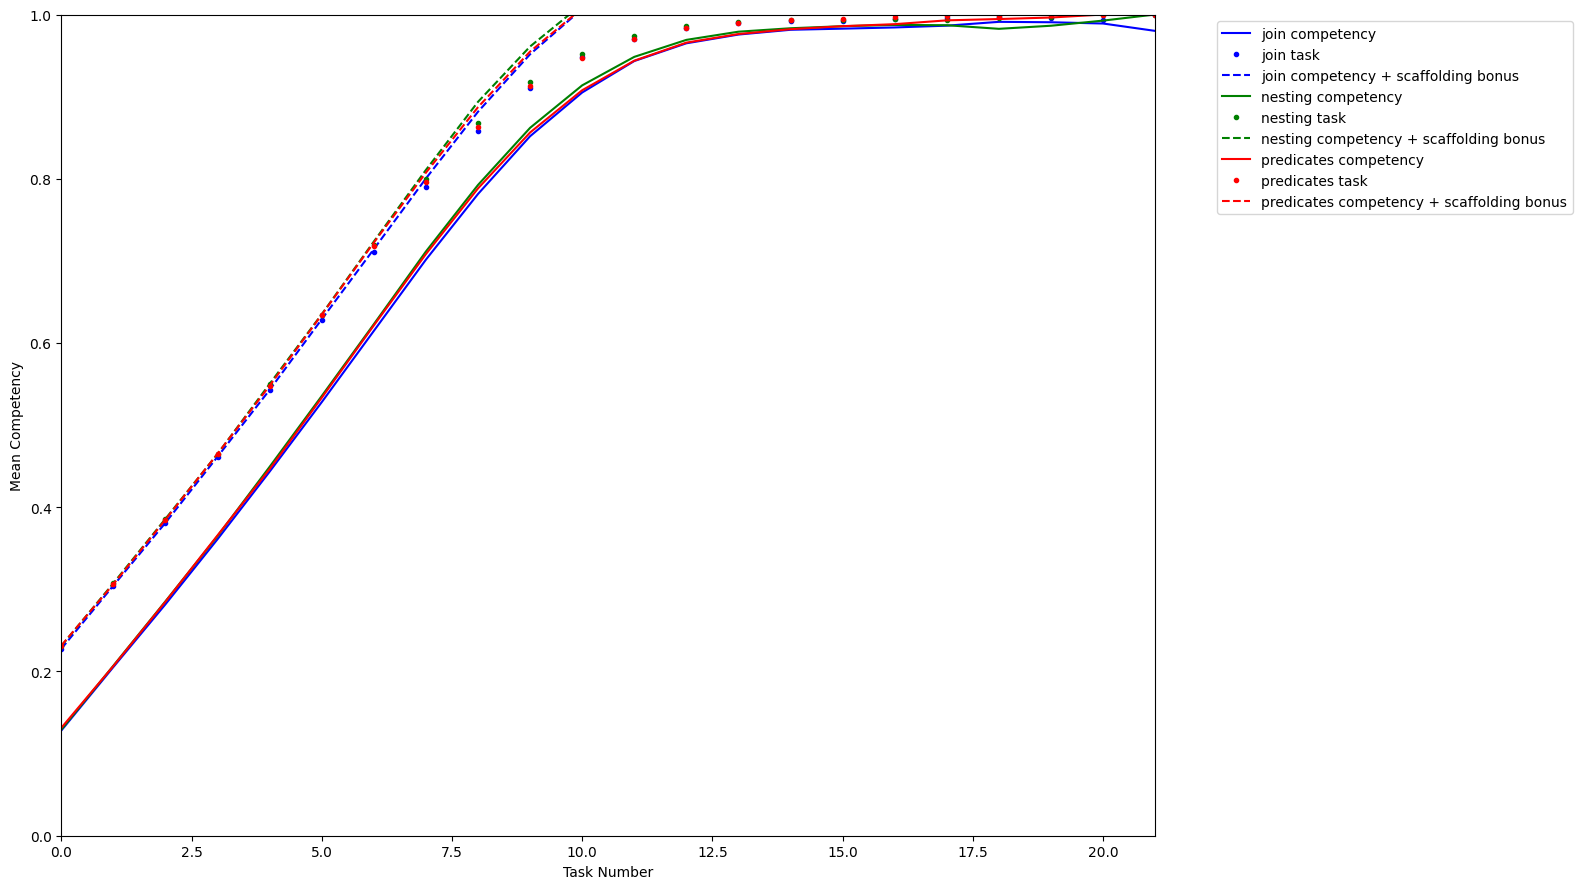

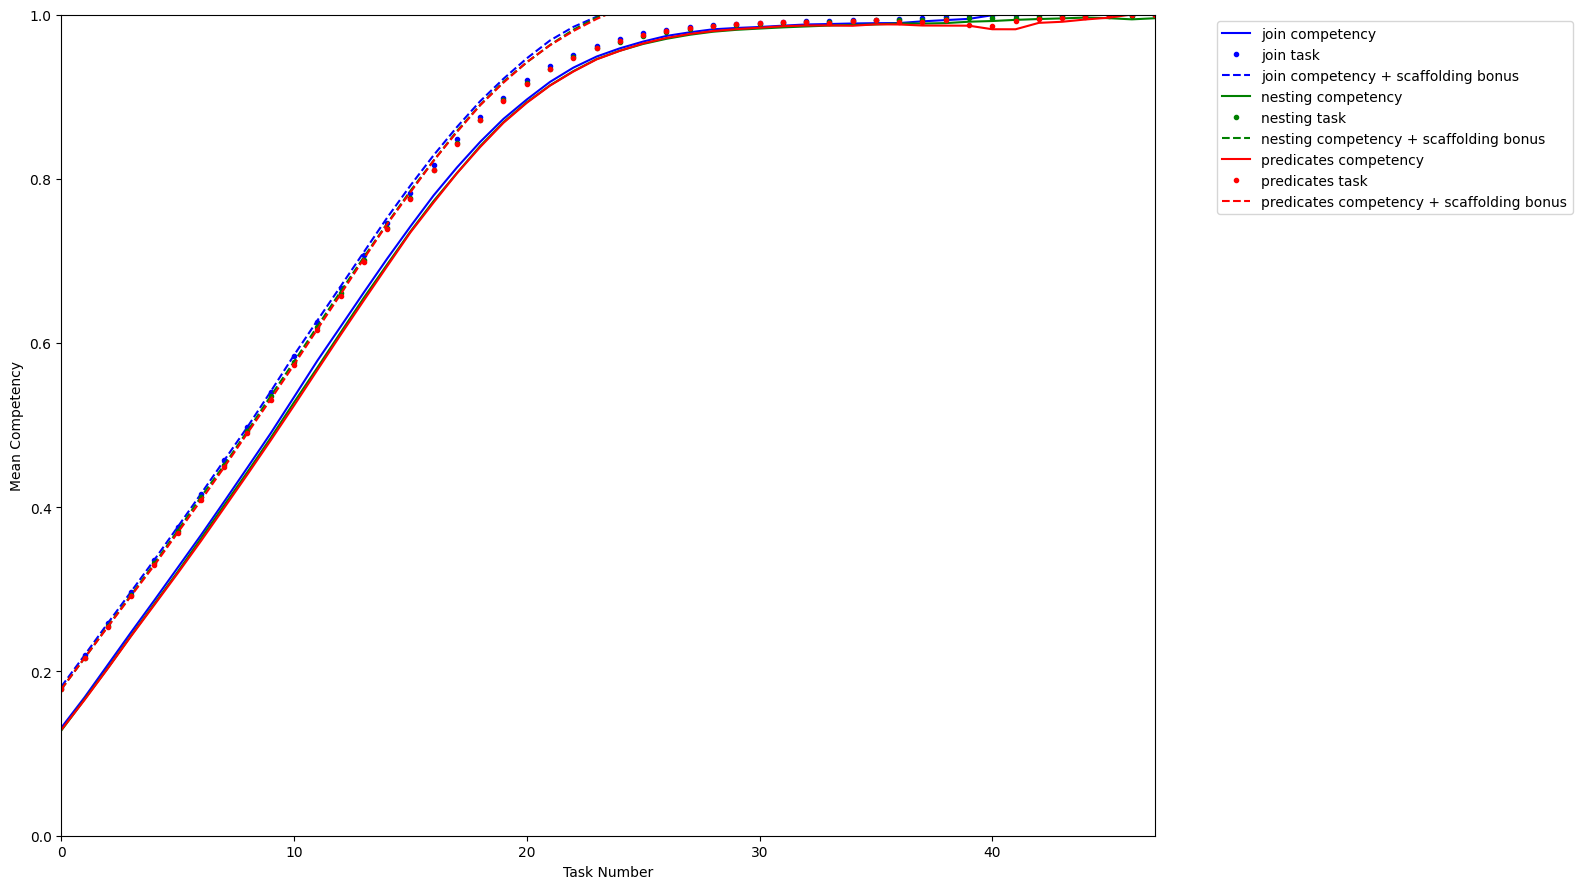

In [36]:

def createSimData(learner_count, mean_competency, bonus_distribution):
    simulationLog = simulate_task_adaptation(learner_count, mean_competency, bonus_distribution)
    plot_mean_simulation_log(simulationLog)
    return simulationLog

# (learner_count, mean_competency, bonus_distribution)
# bonus_distribution = (mean, var, min, max)
simVariations = [
    # average start and fast learning
    (1000, 0.5, (0.2, 0.002, 0.1, 0.3)),
    # average start and average learning
    (1000, 0.5, (0.1, 0.002, 0, 0.2)),
    # average start and slow learning
    (1000, 0.5, (0.05, 0.002, 0, 0.2)),
    
    # good start and fast learning
    (1000, 0.7, (0.2, 0.002, 0.1, 0.3)),
    # good start and average learning
    (1000, 0.7, (0.1, 0.002, 0, 0.2)),
    # good start and slow learning
    (1000, 0.7, (0.05, 0.002, 0, 0.2)),
    
    # bad start and fast learning
    (1000, 0.1, (0.2, 0.002, 0.1, 0.3)),
    # bad start and average learning
    (1000, 0.1, (0.1, 0.002, 0, 0.2)),  
    # bad start and slow learning
    (1000, 0.1, (0.05, 0.002, 0, 0.2)),
]

# Initialize datasets array with the correct length
dataset = np.array([createSimData(*simVariation) for simVariation in simVariations]).flatten()
np.random.shuffle(dataset)

saveData(dataset, 'dataset')

In [37]:
print(dataset.shape)

(9000,)
